In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
     
from netCDF4 import Dataset 
import xarray as xr
#import Nio
import os

import matplotlib.pyplot as plt         # to generate plots
from mpl_toolkits.basemap import Basemap,shiftgrid,addcyclic, cm 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
# reading in the cpc precipitation data

iniyr  = 1948
endyr  = 2017
nyr    = endyr - iniyr +1

inindx = 12*(iniyr-1948)
endndx = 12*(endyr-1948+1)

ncfile2 = '/data/obs_data/CPC_CONUS/monthly/precip.V1.0.mon.mean.nc'

fprc = xr.open_dataset(ncfile2)
fprc = fprc.assign_coords(lon=((fprc.lon + 180) % 360) - 180).sortby('lon')  # Convert lon from 0-359 to -180-179
prc =  fprc.precip[inindx:endndx,:,:]
lon_prc  =  fprc.lon
lat_prc  =  fprc.lat 
time_prc = fprc.time[inindx:endndx]
prc.dims

('time', 'lat', 'lon')

In [3]:
# Converting  monthly precipiation to seasonal precipitation 

def annual_mean(df):
    return df.groupby('time.year').mean(dim = 'time')

prc_seas = prc.groupby('time.season').apply(annual_mean)
prc_seas = prc_seas.transpose(*['year','season','lat','lon'])
prc_seas.dims

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


('year', 'season', 'lat', 'lon')

/home/amirerf/.conda/envs/py35/lib/python3.5/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


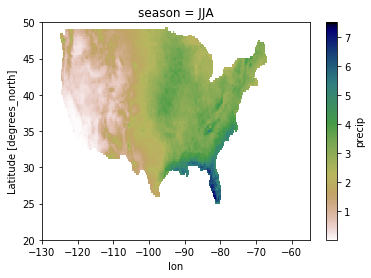

In [6]:
# plotting seasonal mean precipiation for JJA

prc_seas.sel(season='JJA').mean(dim = 'year').plot(cmap='gist_earth_r')

In [39]:
# Calculating seasonal standardized anoamlies

def _standanom(var):
    return  (var - var.mean())/var.std()

def apply_standanom(da, dim):
    return xr.apply_ufunc(_standanom, da, input_core_dims=[[dim]], output_core_dims=[[dim]],
                          vectorize=True,output_dtypes=[da.dtype])

prc_seas_anom = apply_standanom(prc_seas, 'year')

In [40]:
# detrending the seasonal standardized anomalies

def _detrend(var):
    import numpy.polynomial.polynomial as poly
    
    x = np.linspace(1,var.shape[0],var.shape[0])
    y = var.copy()
    b = ~np.isnan(y)
    
    if x[b].size ==0 :
        var_dtn = y
    else:
        coefs = poly.polyfit(x[b], y[b], 1)
        var_coef0 = coefs[0]
        var_coef1 = coefs[1]
        ffit = poly.polyval(x[b], coefs)
        var_dtn = y[b] - ffit + coefs[0]
    
    return var_dtn

def apply_detrend(da, dim):
    return xr.apply_ufunc(_detrend, da, input_core_dims=[[dim]], output_core_dims=[[dim]],
                          vectorize=True,output_dtypes=[da.dtype])

prc_seas_anom_dtrn = apply_detrend(prc_seas_anom, 'year')

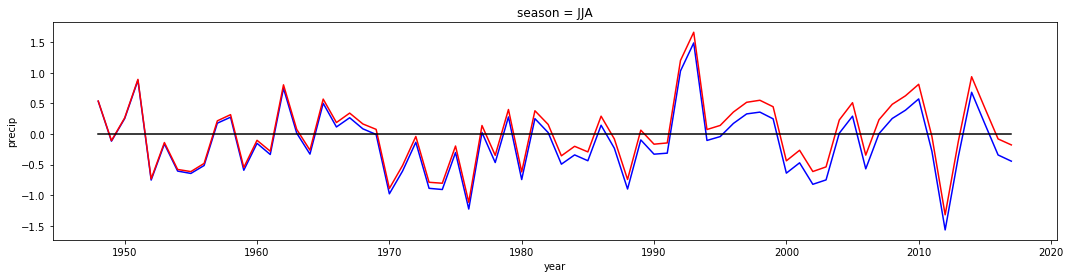

In [95]:
# defining the US GP domain boundaries    
GP = [ 35. , 47. , -105. , -95. ] # [minlat , maxlat, minlon, maxlon] 

# plotting the timeseries of standardized anomalies of summer precipiation averaged over the GP
plt.figure(figsize=(18,4))
prc_seas_anom_dtrn.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon']).plot(color='b')
prc_seas_anom.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon']).plot(color='r')

zero_ax = prc_seas_anom.sel(season='JJA',lat=slice(GP[0],GP[1]),lon=slice(GP[2],GP[3])).mean(dim = ['lat','lon'])
zero_ax[:] = 0.
zero_ax.plot(color='black')